In [ ]:
%%capture
import gc
import os
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import tensorflow_similarity as tfsim
import glob
import shutil
import pathlib
import tensorflow as tf
import cv2 as cv
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up
import pathlib
import pickle
from sklearn.model_selection import KFold

# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpu_devices = tf.config.experimental.list_physical_devices("GPU") 
for device in gpu_devices: 
    tf.config.experimental.set_memory_growth(device, True)

### Load The Raw Data


In [ ]:
IMG_PATH = "path/to/imgs" # that was created earlier from xml2txt.py file containing all images and annotations in same folder

data_dir = pathlib.Path(IMG_PATH ).with_suffix('')

image_files = list(data_dir.glob('*.jpg')) # change extension depending on your images
print(len(image_files))

input_size = 64 # input size MUST be similar to the image size used in the pretraining !! 


In [10]:
# Loading the pretrained model
%%capture
import sys
from  models.official.modeling.optimization.lars_optimizer import LARS

my_model = tf.keras.models.load_model(
    'path/to/your/model/'+'trained_model/', #
    custom_objects={
        "ContrastiveModel": tfsim.models.ContrastiveModel,
        "ActivationStdLoggingLayer": tfsim.layers.ActivationStdLoggingLayer,
        "LARS": LARS
    },
)

In [11]:
def list_files(full_data_path = IMG_PATH , image_ext = '.jpg', split_percentage = 0.8):
    n_classes = 5 # setting number of classes
    files = []
    test_files = []
    n_per_cls = (len(image_files) * (1-split_percentage))//n_classes # fixing images per class in test set for fair evaluation
    discarded = 0
    class_img_cnt = {str(i):0 for i in range(n_classes)}   # dict to count images per class

    for _, _, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # first, let's check if there is only one object
                with open(f"{full_data_path}/{file}", 'r') as fp: 
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        # print (fp)
                        continue
                    

                strip = file[0:len(file) - len(".txt")]  
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    class_instance = lines[0][0]
                    
                    if class_img_cnt[class_instance] >= 450:
                        discarded += 1
                        continue
                    class_img_cnt[class_instance] += 1                     
                    if class_img_cnt[class_instance] <= n_per_cls: # splitting cls equally 
                        test_files.append(strip)
                    else:
                        files.append(strip)

    size = len(files)   
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")

    random.shuffle(files)

    return files, test_files, class_img_cnt


In [12]:
training_files, test_files, class_instances = list_files()
print(str(len(training_files)) + " training files")
print(str(len(test_files)) + " test files")

230 file(s) discarded
1706 valid case(s)
1706 training files
435 test files


In [13]:
# class index can be mapped later from the classes.txt file that 
# the classes.txt file has a list of class names that was generated from xlm2txt file
class_instances

{'0': 439, '1': 390, '2': 412, '3': 450, '4': 450}

In [14]:
def format_image(img, box):
    height, width,_ = img.shape 
    rw = width / input_size
    rh = height / input_size
    new_size = (input_size, input_size)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / rw), int((y - 0.5*h) * height / rh), int(w*width / rw), int(h*height / rh)]

    return resized, new_box

In [15]:
def data_load(files, full_data_path = IMG_PATH):
    X = []
    Y = []
    for file in files:
        img = cv.imread(os.path.join(full_data_path, f'{file}.JPEG'))
        with open(f"{full_data_path}/{file}.txt", 'r') as fp: 
            line = fp.readlines()[0]
            id = line[0] 
            box = np.array(line[1:].split(), dtype=float)
        img, box = format_image(img, box) 
        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        X.append(img)
        Y.append(label)
    print(f" Loaded {len(X)} images")
    X = np.array(X)
    Y = np.array(Y)

    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [16]:
CLASSES = len(class_instances.keys())
# perform one-hot-encoding for classes
# All label indexes below are the bbox coordinates
def format_instance(image, label):
    
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [18]:
BATCH_SIZE = 128
# see https://www.tensorflow.org/guide/data_performance

@tf.function
def img_scaling(img):
    return tf.keras.applications.imagenet_utils.preprocess_input(
        img, 
        data_format=None, 
        mode='torch')
    
def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE) 
    return dataset


In [19]:
def get_backbone(img_size, activation="relu", preproc_mode="torch"):
    input_shape = (img_size, img_size, 3)

    backbone = tfsim.architectures.ResNet18Sim(
        input_shape,
        include_top=False,  # Take the pooling layer as the output.
        pooling="avg",
    )
    return backbone


In [20]:
# learning rate and decay were calcualted first using LR_finder to get the best values
def get_eval_model(img_size, backbone, total_steps, trainable=True,algo = None, lr=0.1):
    if algo == "simsiam":
        lr = 0.02
        decay = 3.162277660168379e-06 #
        opt = tf.keras.optimizers.SGD(lr, momentum=0.9, decay=decay)
        # opt = LARS(learning_rate=lr, weight_decay_rate= decay)

    elif algo == "simclr":
        lr = 0.0031622776601683794
        decay = 0.001
        opt = tf.keras.optimizers.SGD(lr, momentum=0.9,  nesterov= True, decay= decay)

    else: # used to fine-tune supervised model
        decay = 1e-4 
        lr = 0.046415888336127774 
        opt = tf.keras.optimizers.SGD(lr, momentum=0.9, decay=decay)
    
    backbone.trainable = trainable
    inputs = tf.keras.layers.Input((img_size, img_size, 3), name="eval_input")
    x = backbone(inputs, training=trainable)
    classification_head = tf.keras.layers.Dense(CLASSES, activation="softmax", name = 'classifier_head')(x)
    regressor_head = tf.keras.layers.Dense(units = '4', name = 'regressor_head')(x)
    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=opt, 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' }
              )

    return model


In [ ]:
# adapted from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1)
    return dataset

def img_load(file, full_data_path = IMG_PATH, image_ext = ".JPEG", out_size=256):
		'''will be used later when visualizing bbox the image will be scaled for better 
		view in case the training was done on small-sized images'''
        img = cv.imread(os.path.join(full_data_path, f'{file}.JPEG'))
        return cv.resize(img, (256,256), interpolation= cv.INTER_LINEAR)



### Training phase

In [46]:
#### apply k fold for cross-validated training 
ALGORITHM = "simclr" # if the algorithm is not simclr or simsiam, supervised hyperparameters will be used 
TL_PATH = f"/path/to/save/model/{ALGORITHM}/" # change this to your preferred path for saving model 
Histories = {}
res_Histories = {}
res_list = []
ssl_list= []

# Set the number of folds (k)
k = 5
fold_num = -1
# Initialize the KFold object
kf = KFold(n_splits=k, shuffle=True)

# Perform k-fold cross-validation
for train_index, val_index in kf.split(training_files):
    fold_num+=1
    print(f"Starting trial {fold_num} of the training")
    train_data = [training_files[i] for i in train_index]
    val_data = [training_files[i] for i in val_index]
    
    # Use the train_data for training and val_data for val/evaluation
    # Your code here

    raw_train_ds = data_load(train_data)
    raw_validation_ds = data_load(val_data)
    train_ds = tune_training_ds(raw_train_ds)
    validation_ds = tune_validation_ds(raw_validation_ds)
    #### initiate hyperparameters
    EPOCHS = 90
    TEST_STEPS_PER_EPOCH = len(train_data) // BATCH_SIZE
    total_steps = EPOCHS * TEST_STEPS_PER_EPOCH
    VAL_STEPS_PER_EPOCH = len(val_data) // BATCH_SIZE #4
    # starting SSL training
    print("Starting SSL training")
    model = get_eval_model( img_size=input_size,
        backbone=contrastive_model.backbone,
        total_steps=EPOCHS * TEST_STEPS_PER_EPOCH,
        trainable=False,
        algo= ALGORITHM,                         
        )
    history = model.fit(train_ds,
        steps_per_epoch=TEST_STEPS_PER_EPOCH,
        validation_data=validation_ds, 
        validation_steps=VAL_STEPS_PER_EPOCH, 
        epochs=EPOCHS,
        verbose = 2,
        )
    print("Starting Supervised training")
    res_model = get_eval_model(img_size=input_size,
        backbone=get_backbone(input_size),
        total_steps=EPOCHS * TEST_STEPS_PER_EPOCH,
        trainable=False,

        )
    res_history = res_model.fit(train_ds,
        steps_per_epoch=(len(training_files) // BATCH_SIZE),
        validation_data=validation_ds, 
        validation_steps=VAL_STEPS_PER_EPOCH, 
        epochs=EPOCHS,                                     
        )

    Histories[f"history_X{fold_num}"] = history.history
    res_Histories[f"history_X{fold_num}"] = res_history.history
    ssl_list.append(model.evaluate(test_ds))
    res_list.append(res_model.evaluate(test_ds))

    print("SSL pretrain data:", ssl_list[fold_num])
    print("Supervised pretrain data:",  res_list[fold_num])
    
    if fold_num == 0:
        res_model.save(TL_PATH + "trained_model")
        best_model = res_model
    #check if this round's accuracy performs better to save it as our best model    
    elif res_list[fold_num][3] > res_list[fold_num-1][3]: # 3 is the accuracy index
        print("Found new best model")
        res_model.save(TL_PATH + "trained_model")
        best_model = res_model
        

# after all trials are finished    
with open(TL_PATH + f"SSL_e{EPOCHS}_Histories", 'wb') as file_pi:
    pickle.dump(Histories, file_pi)
with open(TL_PATH + f"res_e{EPOCHS}_Histories", 'wb') as file_pi:
    pickle.dump(res_Histories, file_pi)
    



Starting trial 0 of the training
738
738
187
187
Starting SSL training
Starting Supervised training
Epoch 1/90
13/13 [==============================] - 2s 73ms/step - loss: 1.9949 - classifier_head_loss: 1.5990 - regressor_head_loss: 0.3959 - classifier_head_accuracy: 0.2157 - regressor_head_mse: 0.3959 - val_loss: 1.8473 - val_classifier_head_loss: 1.6475 - val_regressor_head_loss: 0.1998 - val_classifier_head_accuracy: 0.1562 - val_regressor_head_mse: 0.1998
Epoch 2/90
13/13 [==============================] - 1s 50ms/step - loss: 1.7332 - classifier_head_loss: 1.6045 - regressor_head_loss: 0.1287 - classifier_head_accuracy: 0.2254 - regressor_head_mse: 0.1287 - val_loss: 1.6659 - val_classifier_head_loss: 1.6386 - val_regressor_head_loss: 0.0274 - val_classifier_head_accuracy: 0.1641 - val_regressor_head_mse: 0.0274
Epoch 3/90
13/13 [==============================] - 1s 50ms/step - loss: 1.6161 - classifier_head_loss: 1.5754 - regressor_head_loss: 0.0407 - classifier_head_accuracy: 0

/home/manaf/.tf_ssl/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/manaf/.tf_ssl/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Starting trial 1 of the training
749
749
176
176
Starting SSL training
Starting Supervised training
Epoch 1/90
13/13 [==============================] - 2s 74ms/step - loss: 1.8250 - classifier_head_loss: 1.6442 - regressor_head_loss: 0.1808 - classifier_head_accuracy: 0.2109 - regressor_head_mse: 0.1808 - val_loss: 1.6602 - val_classifier_head_loss: 1.5674 - val_regressor_head_loss: 0.0929 - val_classifier_head_accuracy: 0.2617 - val_regressor_head_mse: 0.0929
Epoch 2/90
13/13 [==============================] - 1s 52ms/step - loss: 1.6503 - classifier_head_loss: 1.5888 - regressor_head_loss: 0.0615 - classifier_head_accuracy: 0.2302 - regressor_head_mse: 0.0615 - val_loss: 1.5779 - val_classifier_head_loss: 1.5562 - val_regressor_head_loss: 0.0217 - val_classifier_head_accuracy: 0.2266 - val_regressor_head_mse: 0.0217
Epoch 3/90
13/13 [==============================] - 1s 58ms/step - loss: 1.6144 - classifier_head_loss: 1.5846 - regressor_head_loss: 0.0298 - classifier_head_accuracy: 0

/home/manaf/.tf_ssl/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/manaf/.tf_ssl/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Starting trial 3 of the training
740
740
185
185
Starting SSL training
Starting Supervised training
Epoch 1/90
13/13 [==============================] - 2s 74ms/step - loss: 1.7549 - classifier_head_loss: 1.6038 - regressor_head_loss: 0.1511 - classifier_head_accuracy: 0.2782 - regressor_head_mse: 0.1511 - val_loss: 1.6748 - val_classifier_head_loss: 1.5962 - val_regressor_head_loss: 0.0786 - val_classifier_head_accuracy: 0.2617 - val_regressor_head_mse: 0.0786
Epoch 2/90
13/13 [==============================] - 1s 52ms/step - loss: 1.6635 - classifier_head_loss: 1.6160 - regressor_head_loss: 0.0476 - classifier_head_accuracy: 0.2157 - regressor_head_mse: 0.0476 - val_loss: 1.6601 - val_classifier_head_loss: 1.6346 - val_regressor_head_loss: 0.0256 - val_classifier_head_accuracy: 0.1641 - val_regressor_head_mse: 0.0256
Epoch 3/90
13/13 [==============================] - 1s 55ms/step - loss: 1.6172 - classifier_head_loss: 1.5890 - regressor_head_loss: 0.0282 - classifier_head_accuracy: 0

In [26]:
# values in each list: loss | classifier_head_loss| regressor_head_loss| classifier_head_accuracy | regressor_head_mse
print('values in the list:           loss    | classifier_head_loss| regressor_head_loss| classifier_head_accuracy | regressor_head_mse')
# print("all trials SSL pretrain", ssl_list)
print("all trials no pretrain",  res_list)

values in the list:           loss    | classifier_head_loss| regressor_head_loss| classifier_head_accuracy | regressor_head_mse
all trials no pretrain [[1.4471279382705688, 1.434437870979309, 0.01269020326435566, 0.3720000088214874, 0.01269020326435566], [1.4304592609405518, 1.4170629978179932, 0.013395549729466438, 0.3959999978542328, 0.013395549729466438], [1.4587432146072388, 1.446254014968872, 0.012488611973822117, 0.36800000071525574, 0.012488611973822117], [1.4330965280532837, 1.4195154905319214, 0.013581094332039356, 0.41200000047683716, 0.013581094332039356], [1.4945544004440308, 1.481310248374939, 0.013243982568383217, 0.36000001430511475, 0.013243982568383217]]


In [ ]:
# obtain average accuracy
sup_acc, ssl_acc = [], []
for i in res_list:
    sup_acc.append(i[3])
for i in ssl_list:
    ssl_acc.append(i[3])

print(f"Average accuracy of SSL model is %{np.mean(ssl_acc) * 100}")
print(f"Average accuracy of supervised model is %{np.mean(sup_acc) * 100}")

## Testing our best model
 

In [31]:
# Uncomment this in case you already have trained the model and load model directly
# %%capture

# best_model = tf.keras.models.load_model(
#     '/home/manaf/thesis/OD_scratch/TL/simsiam_NoAug/trained_model',
#     custom_objects={
#         "ContrastiveModel": tfsim.models.ContrastiveModel,
#         "ActivationStdLoggingLayer": tfsim.layers.ActivationStdLoggingLayer,
#         "LARS": LARS
#     },
# )

In [ ]:
# processing test set
raw_test_ds = data_load(test_files)
test_ds = tune_test_ds(raw_test_ds)
test_list = list(test_ds.take(-1).as_numpy_iterator())

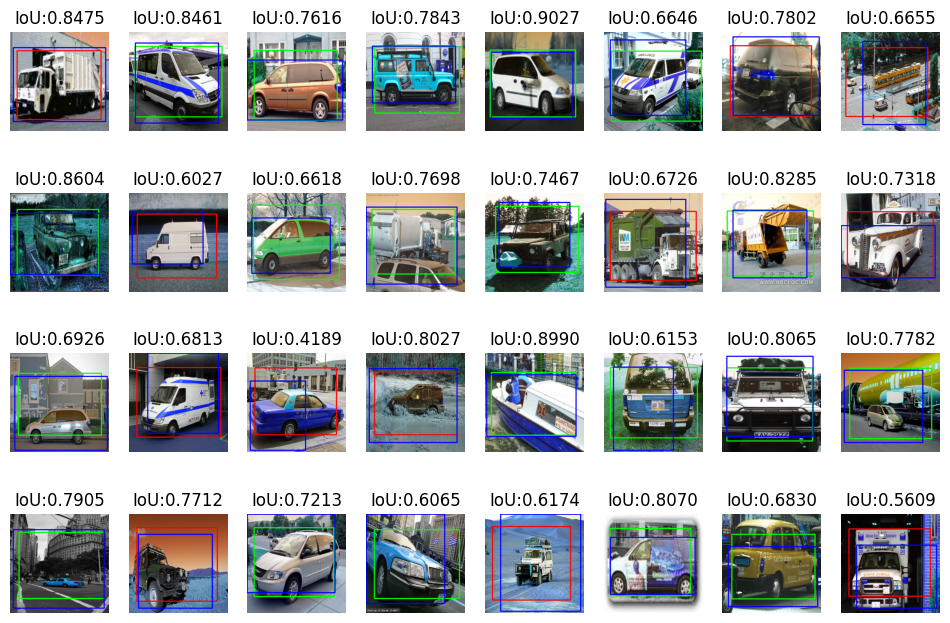

In [30]:
plt.figure(figsize=(12, 8))
y_true, y_pred, iou_values = [] , [], []
out_size = 256  

for i in range(32): # len(test_list)
    ax = plt.subplot(4, 8, i + 1)
    image, labels = test_list[i]

    predictions = best_model(image)
    predicted_box = predictions[1][0] * out_size
    predicted_box = tf.cast(predicted_box, tf.int32)
    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * out_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image_color = image.astype(np.uint8)
    image_color = img_load(test_files[i], out_size= out_size)
    
    # list all predictions
    y_true.append(actual_label.argmax(axis=0))
    y_pred.append(predicted_label.numpy().argmax(axis=0))
    
    color = (0, 255, 0)
    # print box red if predicted and actual label do not match
    if (actual_label.argmax(axis=0) != predicted_label.numpy().argmax(axis=0)):
                color = (255, 0, 0)
    coordinates = np.where(predicted_box.numpy() > 0, predicted_box.numpy(), 0)
    cv.rectangle(image_color, coordinates, color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(coordinates, actual_box.numpy())
    
    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

In [32]:
# get all predictions
y_true, y_pred, res_y_pred, iou_values = [] , [], [], []
for i in range(len(test_list)): 
        image, labels = test_list[i]
        # getting labels    
        predictions = best_model(image)
        predicted_label = predictions[0][0]
        res_predictions = res_model(image)
        res_predicted_label = res_predictions[0][0] 
        actual_label = labels[0][0]

        # getting bounding boxes
        predicted_box = predictions[1][0] * out_size
        predicted_box = tf.cast(predicted_box, tf.int32)        
        actual_box = labels[1][0] * out_size
        actual_box = tf.cast(actual_box, tf.int32)      
        # mAP calculations
        pred_cord = np.where(predicted_box.numpy() > 0, predicted_box.numpy(), 0)
        IoU = intersection_over_union(pred_cord, actual_box.numpy())
        if IoU != 0.0:
                iou_values. append(IoU)

        # list all predictions
        y_true.append(actual_label.argmax(axis=0))
        y_pred.append(predicted_label.numpy().argmax(axis=0))
        res_y_pred.append(res_predicted_label.numpy().argmax(axis=0))   

### heat map

#### self supervised

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# load classes directly also from the classes.txt file
# Or you can write them directly in list format
with open(file_path, "r") as file:
    cls_names = file.read()

# Calculate the confusion matrix
confusion_matrix = np.zeros((CLASSES, CLASSES))
for i in range(len(test_list)): #len(test_list)
    true_label = y_true[i]
    pred_label = y_pred[i]
    confusion_matrix[true_label][pred_label] += 1

# Calculate false positives and false negatives
false_positives = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
false_negatives = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)

# Normalize the false positives and false negatives
normalized_false_positives = false_positives / false_positives.sum()
normalized_false_negatives = false_negatives / false_negatives.sum()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix.astype(int), annot=True, fmt="d", cmap="Reds", xticklabels=cls_names, yticklabels=cls_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Self-Supervised Confusion Matrix")
plt.show()


### supervised

In [ ]:
# Calculate the confusion matrix

confusion_matrix = np.zeros((CLASSES, CLASSES))
for i in range(len(test_list)): #len(test_list)
    true_label = y_true[i]
    pred_label = res_y_pred[i]
    confusion_matrix[true_label][pred_label] += 1

# Calculate false positives and false negatives
false_positives = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
false_negatives = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)

# Normalize the false positives and false negatives
normalized_false_positives = false_positives / false_positives.sum()
normalized_false_negatives = false_negatives / false_negatives.sum()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix.astype(int), annot=True, fmt="d", cmap="Reds", xticklabels=cls_names, yticklabels=cls_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Supervised Confusion Matrix")
plt.show()

### mAP for SSL

In [121]:
def calculate_mAP(iou_values, y_true, y_pred ,threshold=0.5):
    true_positives = []
    false_positives = []
    cumulative_true_positives = []

    for i in range (len(iou_values)):
        if iou_values[i] >= threshold and y_true[i]==y_pred[i]:  
            true_positives.append(1)
            false_positives.append(0)
        else:
            true_positives.append(0)
            false_positives.append(1)

    cumulative_true_positives = np.cumsum(true_positives)

    precision = cumulative_true_positives / (cumulative_true_positives + np.cumsum(false_positives))

    average_precision = np.mean(precision)
    return average_precision

mAP = calculate_mAP(iou_values, y_true, y_pred ,threshold=0.5) #replace y_pred with res_y_pred to see mAP for supervised
print("mAP:", mAP)


mAP: 0.6512661819462873


### Precision, recall, F1, AUC-ROC

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred,average='macro')
recall = recall_score(y_true, y_pred,average='macro')
f1 = f1_score(y_true, y_pred,average='macro')


(accuracy, precision, recall, f1)


(0.7184873949579832, 0.7122020181922939, 0.7099348926935134, 0.710086816969289)

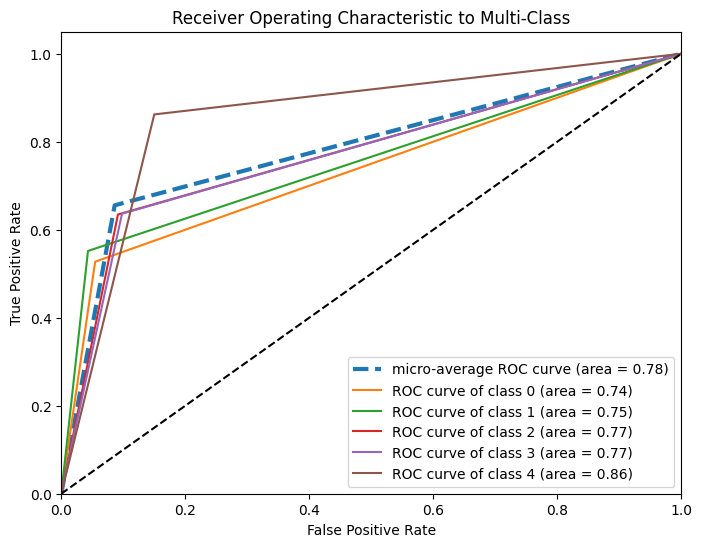

In [33]:
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
# Binarize the output
true_labels_bin = label_binarize(y_true, classes=unique_labels(y_true))
pred_labels_bin = label_binarize(y_pred, classes=unique_labels(y_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(CLASSES):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], pred_labels_bin[:, i])
    roc_auc[i] = roc_auc_score(true_labels_bin[:, i], pred_labels_bin[:, i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_bin.ravel(), pred_labels_bin.ravel())
roc_auc["micro"] = roc_auc_score(true_labels_bin, pred_labels_bin, average="micro")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]), linewidth=3.0, linestyle='--', markerfacecolor='none', markeredgecolor='blue')

for i in range(CLASSES):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-Class')
plt.legend(loc="lower right")
plt.show()


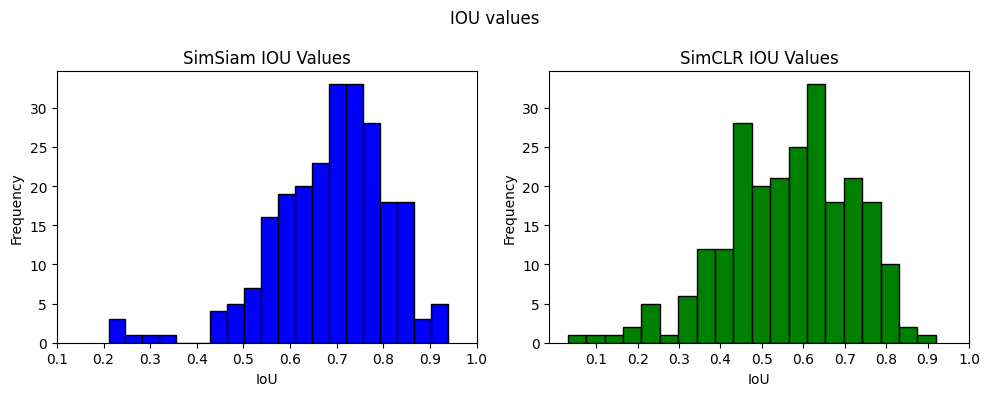

In [124]:
import matplotlib.pyplot as plt

# siam and clr are IoU values were calculated in advance after training both SSL models
# you can run this cell later after training 2 different models to compare their IoU values
fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

# Plotting histograms
axs[0].hist(siam, bins=20, color='blue', edgecolor='black')
axs[0].set_title('SimSiam IOU Values')
axs[0].set_xticks(np.arange(0.1, 1.1, 0.1))  # Adding xticks
axs[0].set_xlabel('IoU')
axs[0].set_ylabel('Frequency')
axs[1].hist(clr, bins=20, color='green', edgecolor='black')
axs[1].set_title('SimCLR IOU Values')
axs[1].set_xticks(np.arange(0.1, 1.1, 0.1))  # Adding xticks
axs[1].set_xlabel('IoU')
axs[1].set_ylabel('Frequency')
plt.suptitle('IOU values')

plt.show()
